# Benchmark 
---
![](./docs/weekly_reports/week2/plot_100.png)


This notebook compares the decoder performance between Viterbi Decoder and Neural Decoder [1] on Convolution Codes over AWGN Channel.

Reference:
* [1] Kim, Hyeji, et al. "Communication Algorithms via Deep Learning." ICLR (2018)


### TODOs:
---

* [x] Benchmark Viterbi Decoder 
* [ ] Benchmark Neural Decoder


In [1]:
import numpy as np
import commpy as cp
import multiprocessing as mp

from deepcom.utils import generate_message_bits

import matplotlib.pyplot as plt
%matplotlib inline

# Dataset

In [3]:
# For reproducability
np.random.seed(2018)

# Paramters for the benchmark
NUM_SEQS = 100
BLOCK_LEN = 100
DATA_RATE = 1/2
CONSTRAINT_LEN = 3
TRACE_BACK_DEPTH = 5 * CONSTRAINT_LEN

# Generate random message bit sequences
msg_bit_sequences = [None for _ in range(NUM_SEQS)]
for i in range(NUM_SEQS):
    message_bits = generate_message_bits(BLOCK_LEN)
    msg_bit_sequences[i] = message_bits
    
# Turn on random state again
np.random.seed()

# Define a Trellis structure

In [5]:
#  Generator Matrix (octal representation)
#  Note 0o7
G = np.array([[0o7, 0o5]]) 
M = np.array([CONSTRAINT_LEN - 1])
trellis = cp.channelcoding.Trellis(M, G, feedback=0o7, code_type='rsc')

# Helper Functions
---

In [7]:
def awgn_channel(input_signal, snr):
    """Simulate data corruption over AWGN channel"""
    signal = 2.0 * input_signal - 1.0
    noise = snr * np.random.standard_normal(input_signal.shape) 
    return signal + noise

def benchmark(message_bits, snr_dB):
    # Encode message bit
    coded_bits = cp.channelcoding.conv_encode(message_bits, trellis)
    
    # Corrupt message on BAWGN Channel
    coded_bits = awgn_channel(coded_bits, snr_dB)
    
    # make fair comparison between (100, 204) convolutional code and RNN decoder
    # Reference: Author's code
    coded_bits[-2*int(M):] = 0
    
    # Viterbi Decoder on Conv. Code
    decoded_bits = cp.channelcoding.viterbi_decode(
        coded_bits=coded_bits.astype(float), 
        trellis=trellis,
        tb_depth=TRACE_BACK_DEPTH,
        decoding_type='unquantized')
    
    # Number of bit errors (hamming distance)
    hamming_dist = cp.utilities.hamming_dist(
        message_bits.astype(int),
        decoded_bits[:-int(M)])
    
    return hamming_dist

# Benchmark Decoder

In [8]:
BERs = []
BLERs = []
SNRs  = np.linspace(-1.5, 2.0, 8)

for snr in SNRs:
    # Decoding sequences in parallel (4= number of available CPU cores)
    with mp.Pool(processes=4) as pool:
        snr_dB = np.sqrt(1 / (2*10.**((snr)/10.)))
        hammming_distances = pool.starmap(
            func=benchmark, 
            iterable=[(msg_bits, snr_dB) for msg_bits in msg_bit_sequences])
    
    # Bit error rate
    ber = sum(hammming_distances) / np.product(np.shape(msg_bit_sequences))
    
    # Block error rate
    bler = np.count_nonzero(hammming_distances) / len(msg_bit_sequences)
    
    BERs.append(ber)
    BLERs.append(bler)
    print('[SNR_dB]={:5.2f} [BLER]={:5.3f} [BER]={:5.7f} '.format(snr_dB, bler, ber))

[SNR_dB]= 0.84 [BLER]=0.640 [BER]=0.0293000 
[SNR_dB]= 0.79 [BLER]=0.480 [BER]=0.0178000 
[SNR_dB]= 0.75 [BLER]=0.320 [BER]=0.0103000 
[SNR_dB]= 0.71 [BLER]=0.200 [BER]=0.0053000 
[SNR_dB]= 0.67 [BLER]=0.100 [BER]=0.0023000 
[SNR_dB]= 0.63 [BLER]=0.060 [BER]=0.0012000 
[SNR_dB]= 0.59 [BLER]=0.030 [BER]=0.0005000 
[SNR_dB]= 0.56 [BLER]=0.020 [BER]=0.0002000 


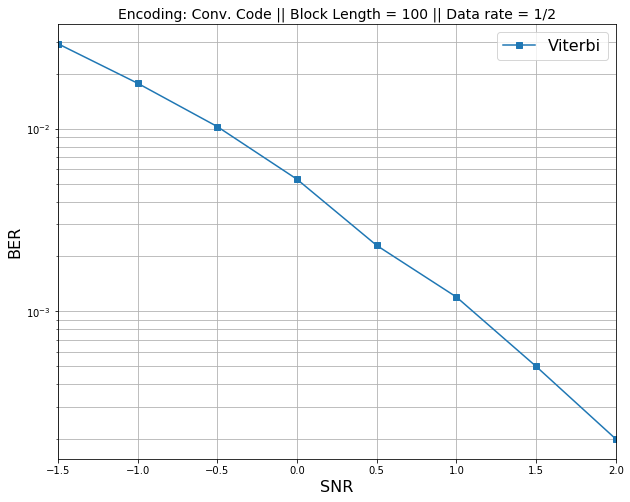

In [12]:
plt.figure(figsize=(10, 8))
plt.title('Encoding: Conv. Code || Block Length = 100 || Data rate = 1/2', fontsize=14)
plt.semilogy(SNRs, BERs, '-s')

plt.legend(['Viterbi'], fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')
plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.savefig('plot_100.png')